Epoch 1/50
83/83 [==============================] - 35s 395ms/step - loss: 0.7388 - accuracy: 0.6972 - val_loss: 0.6690 - val_accuracy: 0.7264 - lr: 0.0010
Epoch 2/50
83/83 [==============================] - 31s 376ms/step - loss: 0.5576 - accuracy: 0.7834 - val_loss: 0.6476 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 3/50
83/83 [==============================] - 32s 381ms/step - loss: 0.5105 - accuracy: 0.8034 - val_loss: 0.7276 - val_accuracy: 0.6926 - lr: 0.0010
Epoch 4/50
83/83 [==============================] - 32s 389ms/step - loss: 0.4931 - accuracy: 0.8056 - val_loss: 0.8830 - val_accuracy: 0.6655 - lr: 0.0010
Epoch 5/50
83/83 [==============================] - 31s 378ms/step - loss: 0.4628 - accuracy: 0.8222 - val_loss: 0.7776 - val_accuracy: 0.7095 - lr: 0.0010
Epoch 6/50
83/83 [==============================] - 31s 377ms/step - loss: 0.3715 - accuracy: 0.8606 - val_loss: 0.7532 - val_accuracy: 0.7399 - lr: 2.0000e-04
Epoch 7/50
83/83 [==============================] - 32s 388m

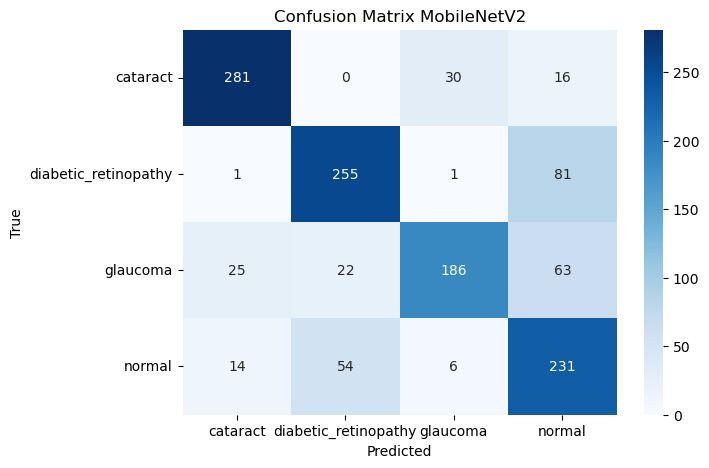

                      precision    recall  f1-score   support

            cataract       0.88      0.86      0.87       327
diabetic_retinopathy       0.77      0.75      0.76       338
            glaucoma       0.83      0.63      0.72       296
              normal       0.59      0.76      0.66       305

            accuracy                           0.75      1266
           macro avg       0.77      0.75      0.75      1266
        weighted avg       0.77      0.75      0.76      1266



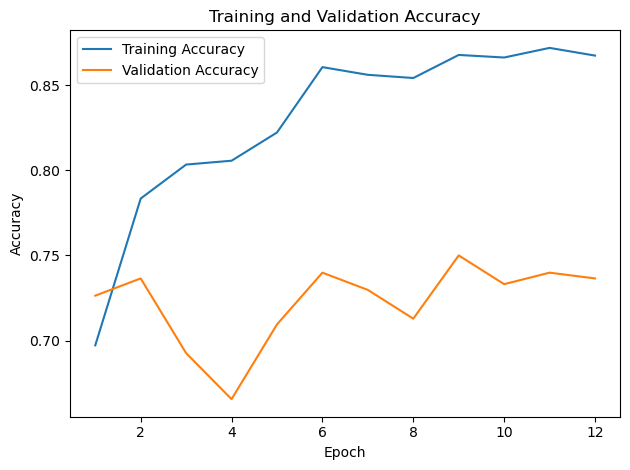

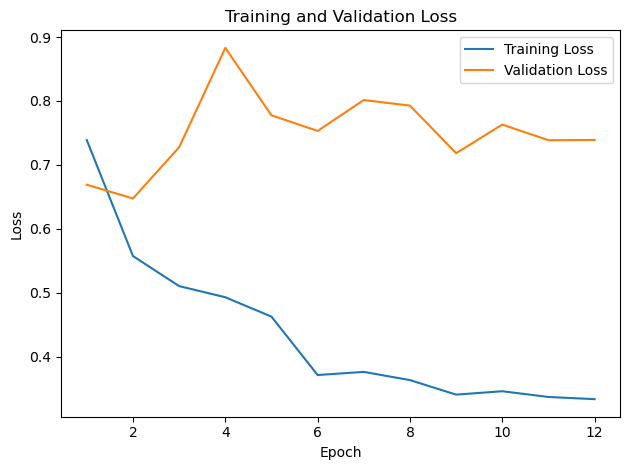

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns

# Set your data and category paths
Data = "C:/Users/USER/Terumbu_karang_CNN/Dataset2"
Categories = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

img_size = 224  # Adjust the image size based on MobileNetV2's input requirements

# Load and preprocess images
def load_and_preprocess_images(data_path, img_size):
    data = []
    labels = []
    for category in Categories:
        path = os.path.join(data_path, category)
        class_num = Categories.index(category)
        for img_name in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, img_name))
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(class_num)
            except Exception as e:
                pass
    data = np.array(data, dtype=np.float32) / 255.0
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(Categories))
    return data, labels

x, y = load_and_preprocess_images(Data, img_size)

# Split data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create your own classifier (top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(Categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with validation data
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Testing the model with testing data
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print("Accuracy on testing data:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(7, 5))  # Adjust the figure size here
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix MobileNetV2')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

# Plot accuracy and loss
# plt.figure(figsize=(12, 6))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.show()

# Plot loss
# plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show()

Epoch 1/50
83/83 [==============================] - 81s 953ms/step - loss: 1.3997 - accuracy: 0.2640 - val_loss: 1.3729 - val_accuracy: 0.2601 - lr: 0.0010
Epoch 2/50
83/83 [==============================] - 79s 948ms/step - loss: 1.3617 - accuracy: 0.3028 - val_loss: 1.3471 - val_accuracy: 0.3277 - lr: 0.0010
Epoch 3/50
83/83 [==============================] - 79s 948ms/step - loss: 1.3263 - accuracy: 0.3484 - val_loss: 1.3095 - val_accuracy: 0.4459 - lr: 0.0010
Epoch 4/50
83/83 [==============================] - 79s 953ms/step - loss: 1.3207 - accuracy: 0.3657 - val_loss: 1.2773 - val_accuracy: 0.4054 - lr: 0.0010
Epoch 5/50
83/83 [==============================] - 79s 952ms/step - loss: 1.3335 - accuracy: 0.3450 - val_loss: 1.3056 - val_accuracy: 0.4155 - lr: 0.0010
Epoch 6/50
83/83 [==============================] - 79s 955ms/step - loss: 1.3154 - accuracy: 0.3653 - val_loss: 1.2559 - val_accuracy: 0.4189 - lr: 0.0010
Epoch 7/50
83/83 [==============================] - 80s 957ms/st

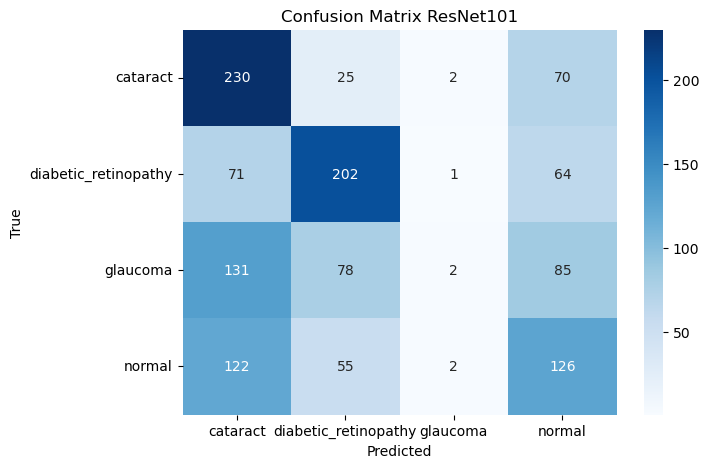

                      precision    recall  f1-score   support

            cataract       0.42      0.70      0.52       327
diabetic_retinopathy       0.56      0.60      0.58       338
            glaucoma       0.29      0.01      0.01       296
              normal       0.37      0.41      0.39       305

            accuracy                           0.44      1266
           macro avg       0.41      0.43      0.38      1266
        weighted avg       0.41      0.44      0.39      1266



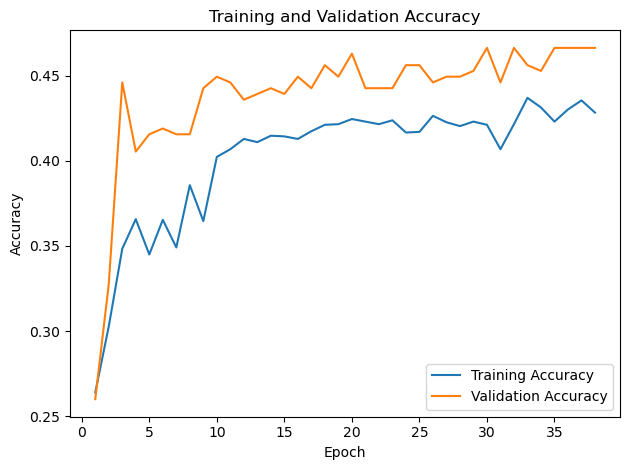

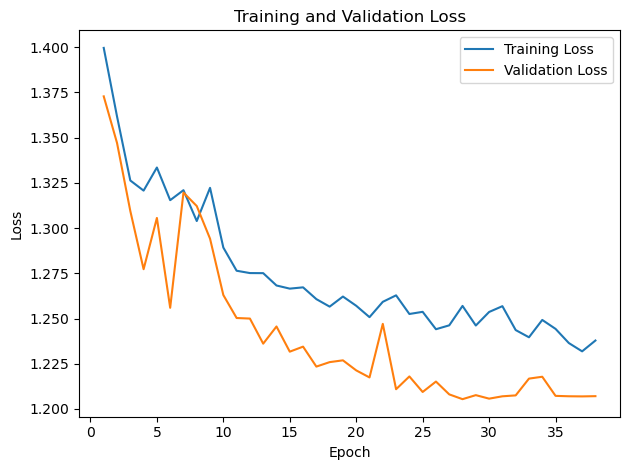

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50 # Change the import statement
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set your data and category paths
# Set your data and category paths
Data = "C:/Users/USER/Terumbu_karang_CNN/Dataset2"
Categories = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

img_size = 224

# Load and preprocess images
def load_and_preprocess_images(data_path, img_size):
    data = []
    labels = []
    for category in Categories:
        path = os.path.join(data_path, category)
        class_num = Categories.index(category)
        for img_name in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, img_name))
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(class_num)
            except Exception as e:
                pass
    data = np.array(data, dtype=np.float32) / 255.0
    labels = to_categorical(labels, num_classes=len(Categories))
    return data, labels

x, y = load_and_preprocess_images(Data, img_size)

# Split data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create and compile the model with ResNet101
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))  # Change the base model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu"),
    Dense(512, activation="relu"),
    Dense(128, activation="relu"),
    Dense(len(Categories), activation='softmax')  # Update the number of output classes
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Classification Report
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy:", np.mean(y_pred_labels == y_true_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix ResNet101')  # Update the title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

# Plot accuracy and loss
# plt.figure(figsize=(12, 6))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.show()

# Plot loss
# plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show()

Epoch 1/50
83/83 [==============================] - 106s 1s/step - loss: 0.7331 - accuracy: 0.7096 - val_loss: 0.8310 - val_accuracy: 0.6689 - lr: 0.0010
Epoch 2/50
83/83 [==============================] - 100s 1s/step - loss: 0.5306 - accuracy: 0.7951 - val_loss: 0.8841 - val_accuracy: 0.6588 - lr: 0.0010
Epoch 3/50
83/83 [==============================] - 98s 1s/step - loss: 0.5097 - accuracy: 0.8004 - val_loss: 0.9430 - val_accuracy: 0.6520 - lr: 0.0010
Epoch 4/50
83/83 [==============================] - 99s 1s/step - loss: 0.4959 - accuracy: 0.7981 - val_loss: 0.7144 - val_accuracy: 0.7230 - lr: 0.0010
Epoch 5/50
83/83 [==============================] - 98s 1s/step - loss: 0.4671 - accuracy: 0.8196 - val_loss: 0.6320 - val_accuracy: 0.7331 - lr: 0.0010
Epoch 6/50
83/83 [==============================] - 99s 1s/step - loss: 0.4470 - accuracy: 0.8279 - val_loss: 0.7782 - val_accuracy: 0.7162 - lr: 0.0010
Epoch 7/50
83/83 [==============================] - 99s 1s/step - loss: 0.4106 -

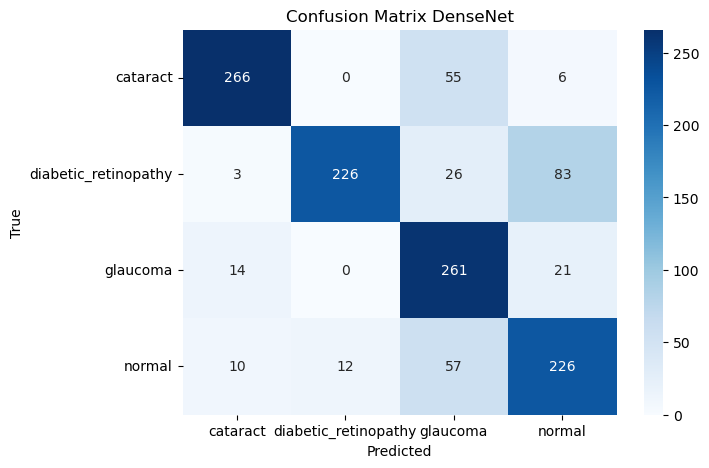

                      precision    recall  f1-score   support

            cataract       0.91      0.81      0.86       327
diabetic_retinopathy       0.95      0.67      0.78       338
            glaucoma       0.65      0.88      0.75       296
              normal       0.67      0.74      0.71       305

            accuracy                           0.77      1266
           macro avg       0.80      0.78      0.77      1266
        weighted avg       0.80      0.77      0.78      1266



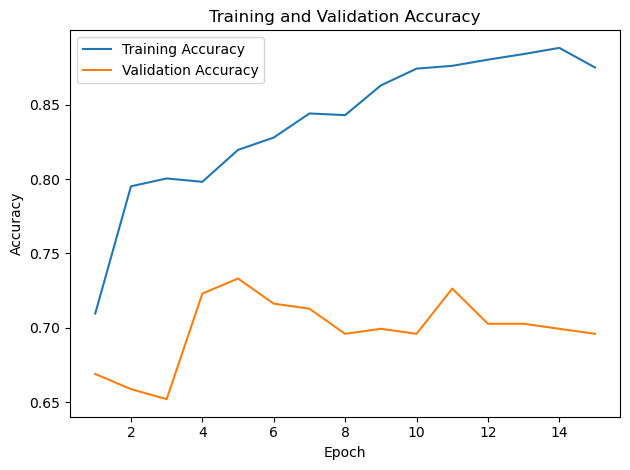

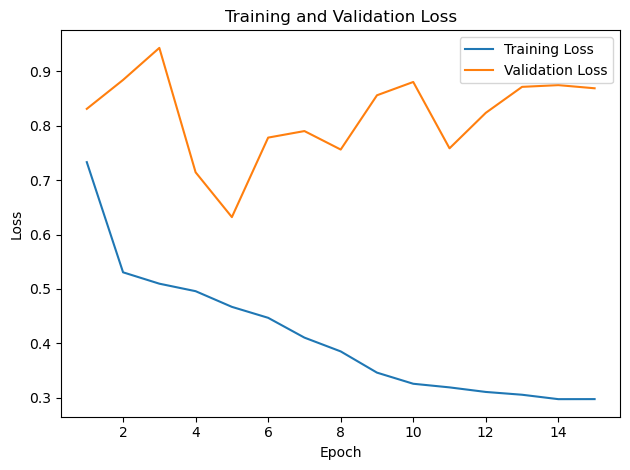

E:\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set your data and category paths
Data = "C:/Users/USER/Terumbu_karang_CNN/Dataset2"
Categories = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

img_size = 224  # Adjust the image size based on DenseNet's input requirements

# Load and preprocess images
def load_and_preprocess_images(data_path, img_size):
    data = []
    labels = []
    for category in Categories:
        path = os.path.join(data_path, category)
        class_num = Categories.index(category)
        for img_name in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, img_name))
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(class_num)
            except Exception as e:
                pass
    data = np.array(data, dtype=np.float32) / 255.0
    labels = to_categorical(labels, num_classes=len(Categories))
    return data, labels

x, y = load_and_preprocess_images(Data, img_size)

# Split data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create your own classifier (top layers)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(len(Categories), activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with validation data
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Testing the model with testing data
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print("Accuracy on testing data:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(7, 5))  # Adjust the figure size here
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix DenseNet')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

# Plot accuracy and loss
# plt.figure(figsize=(12, 6))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.show()

# Plot loss
# plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show()

# Save the trained model
model.save("EfficientNet_EyeDisease.h5")

Epoch 1/50
83/83 [==============================] - 235s 3s/step - loss: 0.7701 - accuracy: 0.6957 - val_loss: 0.8562 - val_accuracy: 0.6554 - lr: 0.0010
Epoch 2/50
83/83 [==============================] - 224s 3s/step - loss: 0.6475 - accuracy: 0.7356 - val_loss: 0.7475 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 3/50
83/83 [==============================] - 222s 3s/step - loss: 0.5908 - accuracy: 0.7631 - val_loss: 0.7486 - val_accuracy: 0.6926 - lr: 0.0010
Epoch 4/50
83/83 [==============================] - 222s 3s/step - loss: 0.5483 - accuracy: 0.7763 - val_loss: 0.9014 - val_accuracy: 0.6419 - lr: 0.0010
Epoch 5/50
83/83 [==============================] - 222s 3s/step - loss: 0.5136 - accuracy: 0.7959 - val_loss: 0.8884 - val_accuracy: 0.6520 - lr: 0.0010
Epoch 6/50
83/83 [==============================] - 224s 3s/step - loss: 0.4658 - accuracy: 0.8105 - val_loss: 0.6849 - val_accuracy: 0.6993 - lr: 2.0000e-04
Epoch 7/50
83/83 [==============================] - 225s 3s/step - loss:

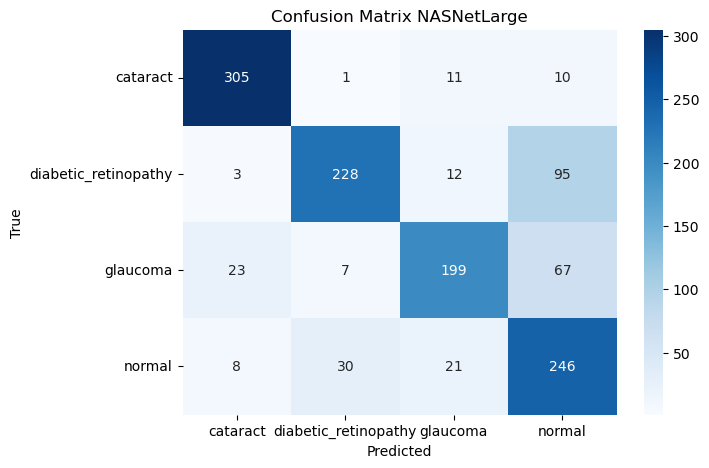

                      precision    recall  f1-score   support

            cataract       0.90      0.93      0.92       327
diabetic_retinopathy       0.86      0.67      0.75       338
            glaucoma       0.82      0.67      0.74       296
              normal       0.59      0.81      0.68       305

            accuracy                           0.77      1266
           macro avg       0.79      0.77      0.77      1266
        weighted avg       0.79      0.77      0.77      1266



C:\Users\USER\AppData\Local\Temp\ipykernel_31952\1664705250.py:129: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


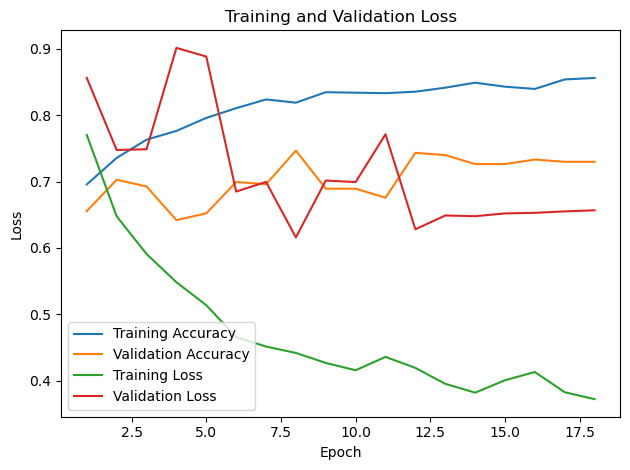

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Flatten
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set your data and category paths
Data = "C:/Users/USER/Terumbu_karang_CNN/Dataset2"
Categories = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

img_size = 224

# Load and preprocess images
def load_and_preprocess_images(data_path, img_size):
    data = []
    labels = []
    for category in Categories:
        path = os.path.join(data_path, category)
        class_num = Categories.index(category)
        for img_name in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, img_name))
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(class_num)
            except Exception as e:
                pass
    data = np.array(data, dtype=np.float32) / 255.0
    labels = to_categorical(labels, num_classes=len(Categories))
    return data, labels

x, y = load_and_preprocess_images(Data, img_size)

# Split data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create and compile the model with NASNetLarge
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dense(len(Categories), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Classification Report
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy:", np.mean(y_pred_labels == y_true_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix NASNetLarge')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

# Plot accuracy and loss
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show()


Epoch 1/50
83/83 [==============================] - 52s 573ms/step - loss: 1.4568 - accuracy: 0.2520 - val_loss: 1.4746 - val_accuracy: 0.2838 - lr: 0.0010
Epoch 2/50
83/83 [==============================] - 46s 557ms/step - loss: 1.4090 - accuracy: 0.2667 - val_loss: 1.8358 - val_accuracy: 0.2331 - lr: 0.0010
Epoch 3/50
83/83 [==============================] - 46s 556ms/step - loss: 1.4066 - accuracy: 0.2399 - val_loss: 1.5667 - val_accuracy: 0.2331 - lr: 0.0010
Epoch 4/50
83/83 [==============================] - 47s 559ms/step - loss: 1.3974 - accuracy: 0.2286 - val_loss: 1.7229 - val_accuracy: 0.2466 - lr: 0.0010
Epoch 5/50
83/83 [==============================] - 47s 559ms/step - loss: 1.3880 - accuracy: 0.2599 - val_loss: 1.4325 - val_accuracy: 0.2466 - lr: 2.0000e-04
Epoch 6/50
83/83 [==============================] - 46s 558ms/step - loss: 1.3864 - accuracy: 0.2701 - val_loss: 1.4037 - val_accuracy: 0.2331 - lr: 2.0000e-04
Epoch 7/50
83/83 [==============================] - 47s 

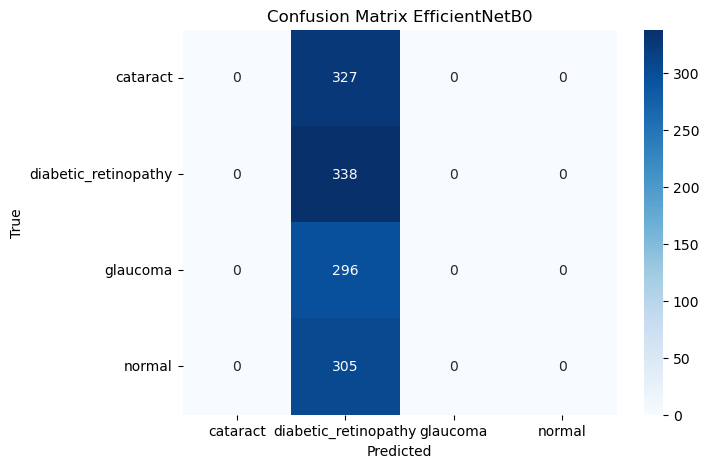

                      precision    recall  f1-score   support

            cataract       0.00      0.00      0.00       327
diabetic_retinopathy       0.27      1.00      0.42       338
            glaucoma       0.00      0.00      0.00       296
              normal       0.00      0.00      0.00       305

            accuracy                           0.27      1266
           macro avg       0.07      0.25      0.11      1266
        weighted avg       0.07      0.27      0.11      1266



E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_31952\2433655609.py:131: UserWarning: The figure

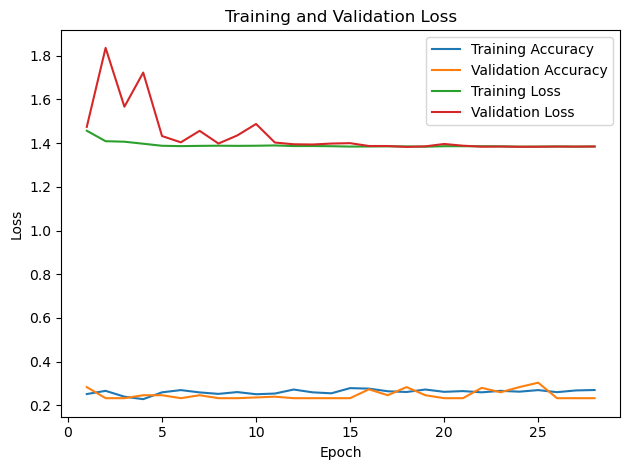

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set your data and category paths
Data = "C:/Users/USER/Terumbu_karang_CNN/Dataset2"
Categories = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

img_size = 224

# Load and preprocess images
def load_and_preprocess_images(data_path, img_size):
    data = []
    labels = []
    for category in Categories:
        path = os.path.join(data_path, category)
        class_num = Categories.index(category)
        for img_name in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, img_name))
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(class_num)
            except Exception as e:
                pass
    data = np.array(data, dtype=np.float32) / 255.0
    labels = to_categorical(labels, num_classes=len(Categories))
    return data, labels

x, y = load_and_preprocess_images(Data, img_size)

# Split data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create and compile the model with EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dense(len(Categories), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Continue with the rest of your code for evaluation and plotting
# ...

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Classification Report
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Accuracy:", np.mean(y_pred_labels == y_true_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix EfficientNetB0')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

# Plot accuracy and loss
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show()
